In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from data_processing import *
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import optuna
import random

import numpy as np
from tqdm import tqdm
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [3]:
### Load data
data_dir = "../../01_Datenaufbereitung/Output/Calculated/"
all_data = load_data(data_dir)


Found 15 parquet files


Processing cells:   0%|          | 0/15 [00:00<?, ?cell/s]

Processing C01 ...


Processing cells:   7%|▋         | 1/15 [00:13<03:13, 13.80s/cell]

Processing C03 ...


Processing cells:  13%|█▎        | 2/15 [00:21<02:13, 10.26s/cell]

Processing C05 ...


Processing cells:  20%|██        | 3/15 [00:29<01:50,  9.19s/cell]

Processing C07 ...


Processing cells:  27%|██▋       | 4/15 [00:36<01:33,  8.48s/cell]

Processing C09 ...


Processing cells:  33%|███▎      | 5/15 [00:40<01:07,  6.80s/cell]

Processing C11 ...


Processing cells:  40%|████      | 6/15 [00:44<00:53,  5.92s/cell]

Processing C13 ...


Processing cells:  47%|████▋     | 7/15 [00:46<00:36,  4.53s/cell]

Processing C15 ...


Processing cells:  53%|█████▎    | 8/15 [00:49<00:27,  3.97s/cell]

Processing C17 ...


Processing cells:  60%|██████    | 9/15 [00:56<00:30,  5.02s/cell]

Processing C19 ...


Processing cells:  67%|██████▋   | 10/15 [01:03<00:28,  5.63s/cell]

Processing C21 ...


Processing cells:  73%|███████▎  | 11/15 [01:10<00:23,  5.89s/cell]

Processing C23 ...


Processing cells:  80%|████████  | 12/15 [01:17<00:18,  6.20s/cell]

Processing C25 ...


Processing cells:  87%|████████▋ | 13/15 [01:21<00:11,  5.60s/cell]

Processing C27 ...


Processing cells:  93%|█████████▎| 14/15 [01:27<00:05,  5.81s/cell]

Processing C29 ...


Processing cells: 100%|██████████| 15/15 [01:29<00:00,  5.97s/cell]


In [4]:
train_df, val_df, test_df = split_data(all_data, train=13, val=1, test=1,parts = 1)
train_scaled, val_scaled, test_scaled = scale_data(train_df, val_df, test_df)

Cell split completed:
Training set: 13 cells
Validation set: 1 cells
Test set: 1 cells
Final dataset sizes:
Training set: 274217 rows (split into 13 parts)
Validation set: 26791 rows from 1 cells
Test set: 27189 rows from 1 cells


In [10]:
val_scaled['cell_id'].unique()

array(['C23'], dtype=object)

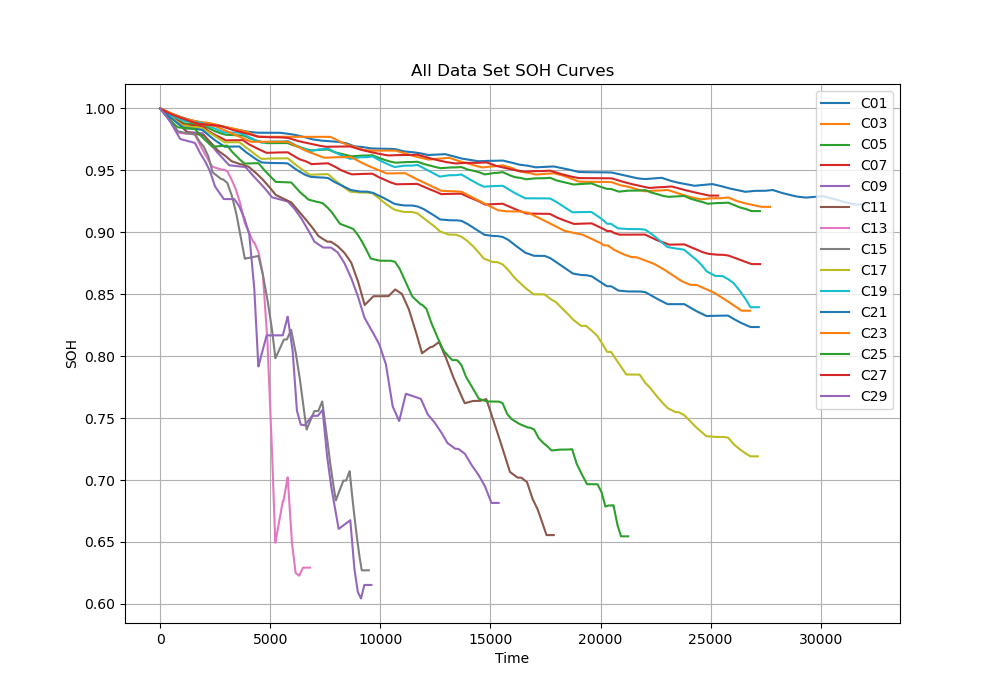

In [7]:
### Visualize data
# visualize_data(all_data)
# inspect_data_ranges(all_data)
# inspect_data_ranges(train_scaled)
# plot_dataset_soh(train_df, "Train")
# plot_dataset_soh(val_df, "Validation")
# plot_dataset_soh(test_df, "Test")
plot_dataset_soh(all_data, "All Data")

In [16]:
### Sequence Dataset
class SequenceDataset(Dataset):
    def __init__(self, df, seed_len=36, pred_len=5):
        self.seed_len = seed_len
        self.pred_len = pred_len
        #  [SOH_ZHU, Current, Voltage, Temperature]
        self.data_all = df[['SOH_ZHU', 'Current[A]', 'Voltage[V]', 'Temperature[°C]']].values

    def __len__(self):
        return len(self.data_all) - (self.seed_len + self.pred_len) + 1

    def __getitem__(self, idx):
        block = self.data_all[idx : idx + self.seed_len + self.pred_len]
        # block shape: (seed_len + pred_len, 4)

        # [0 : seed_len], [seed_len : seed_len + pred_len]
        x_seed = block[:self.seed_len]          # (seed_len, 4)
        x_future = block[self.seed_len:]        # (pred_len, 4)

        # 目标只取这 pred_len 行的第 0 列
        y_target = x_future[:, 0]  # shape (pred_len, )
        return (
            torch.tensor(x_seed, dtype=torch.float32),
            torch.tensor(x_future, dtype=torch.float32),
            torch.tensor(y_target, dtype=torch.float32)
        )



# Using ground truth of SOH and 3 covariances
seq_length=13
pred_length= 1
batch_size=16
train_dataset = SequenceDataset(train_scaled, seed_len=seq_length, pred_len=pred_length)
val_dataset = SequenceDataset(val_scaled, seed_len=seq_length, pred_len=pred_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


In [5]:
class LSTMSOH(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_layers: int, dropout: float):
        super(LSTMSOH, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout= dropout)
        # Attention layer: project hidden state at each time step to a scalar attention weight
        # self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, dtype=x.dtype, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, dtype=x.dtype, device=x.device)
        lstm_out, _ = self.lstm(x,(h0,c0))  # lstm_out shape: (batch_size, seq_len, hidden_dim)
        
        # # # Compute attention scores and normalize them
        # attn_scores = self.attention(lstm_out)  # shape: (batch_size, seq_len, 1)
        # attn_weights = torch.softmax(attn_scores, dim=1)  # softmax over seq_len
        
        # # # Compute the context vector as the weighted sum of LSTM outputs
        # context = torch.sum(attn_weights * lstm_out, dim=1)  # shape: (batch_size, hidden_dim)
        # out = self.fc(context)  # Final prediction, shape: (batch_size, 1)
        
        out = self.fc(lstm_out[:,-1,:]) # (batch_size, hidden_dim) -> (batch_size, 1)
        
        return out.squeeze(-1) #(batch_size,)

In [13]:
class BatteryCellDataset(Dataset):
    def __init__(self, df, seed_len, pred_len, is_train=True):
        """
        df: DataFrame 包含列:
            - SOH_ZHU
            - Current[A]
            - Voltage[V]
            - Temperature[°C]
            - cell_id
            - Testtime[h]
        is_train: 是否是训练模式
        """
        self.df = df
        self.seed_len = seed_len
        self.pred_len = pred_len
        self.is_train = is_train
        
        # 获取所有唯一的 cell_id
        self.unique_cells = df['cell_id'].unique()
        
        # 预处理每个cell的数据点
        self.samples = []
        for cell_id in self.unique_cells:
            cell_data = df[df['cell_id'] == cell_id]
            cell_data = cell_data.sort_values('Testtime[h]').reset_index(drop=True)
            
            if is_train:
                # 训练模式：使用滑动窗口
                for i in range(len(cell_data) - seed_len - pred_len + 1):
                    self.samples.append({
                        'cell_id': cell_id,
                        'start_idx': i
                    })
            else:
                # 验证/测试模式：连续预测
                for i in range(0, len(cell_data) - seed_len - pred_len + 1, pred_len):
                    self.samples.append({
                        'cell_id': cell_id,
                        'start_idx': i
                    })
    
    def shuffle_samples(self):
        """仅在训练模式下打乱样本"""
        if self.is_train:
            random.shuffle(self.samples)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        cell_id = sample['cell_id']
        start_idx = sample['start_idx']
        
        cell_data = self.df[self.df['cell_id'] == cell_id].sort_values('Testtime[h]')
        features = ['SOH_ZHU', 'Current[A]', 'Voltage[V]', 'Temperature[°C]']
        sequence = cell_data[features].iloc[start_idx:start_idx + self.seed_len + self.pred_len].values
        
        X_seed = sequence[:self.seed_len]
        X_future = sequence[self.seed_len:]
        Y_target = sequence[self.seed_len:, 0]
        
        return torch.FloatTensor(X_seed), torch.FloatTensor(X_future), torch.FloatTensor(Y_target), cell_id

def create_data_loaders(train_df, val_df, seed_len, pred_len, batch_size):
    """创建训练和验证数据加载器"""
    train_dataset = BatteryCellDataset(train_df, seed_len, pred_len, is_train=True)
    val_dataset = BatteryCellDataset(val_df, seed_len, pred_len, is_train=False)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,  # 使用dataset级别的shuffle
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,  # 验证保持顺序
        drop_last=False
    )
    
    return train_loader, val_loader

class LSTMSOH(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=80, num_layers=2, dropout=0.1, pred_len=10):
        super(LSTMSOH, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.pred_len = pred_len
        
        # Encoder LSTM
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, 
                             batch_first=True, dropout=dropout)
        
        # Decoder LSTM
        self.decoder = nn.LSTM(input_dim, hidden_dim, num_layers,
                             batch_first=True, dropout=dropout)
        
        # Projection layer
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x: torch.Tensor, future_features: torch.Tensor = None) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_dim)
            future_features: Future known features (batch_size, pred_len, input_dim-1)
        Returns:
            predictions: Predictions of shape (batch_size, pred_len)
        """
        batch_size = x.size(0)
        device = x.device
        
        # Initialize hidden states
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, 
                        dtype=x.dtype, device=device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, 
                        dtype=x.dtype, device=device)
        
        # Encode the input sequence
        _, (hidden, cell) = self.encoder(x, (h0, c0))
        
        # Initialize decoder input with the last step of input sequence
        decoder_input = x[:, -1:, :]
        
        # Store predictions
        predictions = []
        
        # Decode step by step
        for t in range(self.pred_len):
            # Get prediction for current step
            decoder_output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            current_pred = self.fc(decoder_output[:, -1:, :])  # Shape: (batch_size, 1, 1)
            predictions.append(current_pred.squeeze(-1)) # Shape: (batch_size,)
            
            # Prepare next input
            if future_features is not None:
                # Combine prediction with known future features
                next_input = torch.cat([
                    current_pred,
                    future_features[:, t:t+1, :]  # Known features for next step
                ], dim=-1)
            else:
                # If no future features provided, use zeros
                next_features = torch.zeros(batch_size, 1, x.size(-1)-1, device=device)
                next_input = torch.cat([current_pred, next_features], dim=-1)
            
            decoder_input = next_input
        
        # Stack predictions along time dimension
        predictions = torch.stack(predictions, dim=1)  # Shape: (batch_size, pred_len)
        
        return predictions


def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    history = {
        'train_loss': [], 'val_loss': [],
        'val_mae': [], 'val_rmse': [], 'val_r2': []
    }
    
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # -----------------------------
        # 1) Training Loop 
        # -----------------------------
        model.train()
        train_loader.dataset.shuffle_samples()
        train_losses = []
        
        for X_seed, X_future, Y_target, _ in train_loader:
            X_seed = X_seed.to(device)
            X_future = X_future.to(device)
            Y_target = Y_target.to(device)
            
            # 提取未来时间步的已知特征（电流、电压、温度）
            future_features = X_future[:, :, 1:]  # 除去SOH列的其他特征
            
            # 直接进行多步预测
            predictions = model(X_seed, future_features)
            
            # 计算损失
            loss = criterion(predictions, Y_target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
        
        mean_train_loss = np.mean(train_losses)
        history['train_loss'].append(mean_train_loss)
        
        # -----------------------------
        # 2) Validation Loop 
        # -----------------------------
        model.eval()
        val_losses = []
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for X_seed, X_future, Y_target, _ in val_loader:
                X_seed = X_seed.to(device)
                X_future = X_future.to(device)
                Y_target = Y_target.to(device)
                
                # 提取未来时间步的已知特征
                future_features = X_future[:, :, 1:]
                
                # 直接进行多步预测
                predictions = model(X_seed, future_features)
                
                val_loss = criterion(predictions, Y_target)
                val_losses.append(val_loss.item())
                
                all_preds.append(predictions.cpu().numpy())
                all_targets.append(Y_target.cpu().numpy())

        # 计算验证指标
        mean_val_loss = np.mean(val_losses)
        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)
        
        mae = mean_absolute_error(all_targets, all_preds)
        rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
        r2 = r2_score(all_targets, all_preds)
        
        history['val_loss'].append(mean_val_loss)
        history['val_mae'].append(mae)
        history['val_rmse'].append(rmse)
        history['val_r2'].append(r2)
        
        print(f"\nEpoch [{epoch+1}/{num_epochs}] Summary: "
              f"Train Loss: {mean_train_loss:.4e} | "
              f"Val Loss: {mean_val_loss:.4e} | "
              f"MAE: {mae:.4e} | RMSE: {rmse:.4e} | R2: {r2:.4f}")
        
        # Early Stopping
        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    return history, best_model_state


# 使用示例
seed_len = 100  # 根据实际需求设置
pred_len = 50   # 根据实际需求设置
batch_size = 32 # 根据实际需求设置

# 创建数据加载器
train_loader, val_loader = create_data_loaders(
    train_df, val_df, 
    seed_len, pred_len, 
    batch_size
)

# 创建模型和优化器
model = LSTMSOH(input_dim=4, hidden_dim=80, num_layers=5, dropout=0.5, pred_len=pred_len).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(), 
    lr=1.4296450393279462e-05, 
    weight_decay=0.00012
)

# 训练模型
history, best_model_state = train_model(
    model, criterion, optimizer, 
    train_loader, val_loader, 
    num_epochs=100, patience=10
)

# 保存最佳模型
torch.save(best_model_state, "best_model.pth")


def evaluate_singlepass(model, df, seed_len=100, pred_len=50):
    model.eval()
    features = ['SOH_ZHU', 'Current[A]', 'Voltage[V]', 'Temperature[°C]']
    data_array = df[features].values.copy()
    preds = np.full(len(data_array), np.nan)
    
    with torch.no_grad():
        for i in range(seed_len, len(data_array) - pred_len + 1, pred_len):
            # 获取输入序列
            input_seq = data_array[i - seed_len : i]
            # 获取未来特征
            future_features = data_array[i:i + pred_len, 1:]
            
            # 转换为张量并添加批次维度
            x_t = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
            future_t = torch.tensor(future_features, dtype=torch.float32).unsqueeze(0).to(device)
            
            # 进行多步预测
            predictions = model(x_t, future_t)
            
            # 保存预测结果
            preds[i:i + pred_len] = predictions.cpu().numpy().squeeze()
            
            # 更新数据数组中的SOH值，用于下一个预测窗口
            data_array[i:i + pred_len, 0] = predictions.cpu().numpy().squeeze()
    
    return preds

all_preds = evaluate_singlepass(model, test_scaled, seed_len=seed_len, pred_len=pred_len)
all_targets = test_scaled['SOH_ZHU'].values

valid_preds = all_preds[13:]
valid_targets = all_targets[13:]   

r2 = r2_score(valid_targets, valid_preds)
mae = mean_absolute_error(valid_targets, valid_preds)
rmse = np.sqrt(mean_squared_error(valid_targets, valid_preds))
    
print(f"R2:{r2:.5f} | MAE: {mae:.5e} | RMSE:{rmse:.5e}")

KeyboardInterrupt: 

In [8]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_mae': [],
        'val_rmse': [],
        'val_r2': []
    }
    
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # -----------------------------
        # 1) Training Loop 
        # -----------------------------
        model.train()
        train_losses = []
        
        for X_seed, X_future, Y_target in train_loader:
            X_seed = X_seed.to(device)
            X_future = X_future.to(device)
            Y_target = Y_target.to(device)
            
            current_seq = X_seed.clone()
            preds_steps = []
            pred_len = Y_target.shape[1]
            
            for step in range(pred_len):
                pred = model(current_seq)  # (batch_size,)
                preds_steps.append(pred.unsqueeze(1))
                
                next_frame = X_future[:, step, :].clone()
                next_frame[:, 0] = pred
                current_seq = torch.cat([current_seq[:, 1:, :], next_frame.unsqueeze(1)], dim=1)
            
            preds_steps = torch.cat(preds_steps, dim=1)  # (batch_size, pred_len)
            loss = criterion(preds_steps, Y_target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
        
        mean_train_loss = np.mean(train_losses)
        history['train_loss'].append(mean_train_loss)
        
        # -----------------------------
        # 2) Validation Loop 
        # -----------------------------
        model.eval()
        val_losses = []
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for X_seed, X_future, Y_target in val_loader:
                X_seed = X_seed.to(device)
                X_future = X_future.to(device)
                Y_target = Y_target.to(device)
                
                current_seq = X_seed.clone()
                preds_steps = []
                
                for t in range(Y_target.shape[1]):
                    pred = model(current_seq)  # (batch_size,)
                    preds_steps.append(pred.unsqueeze(1))
                    
                    next_frame = X_future[:, t, :].clone()
                    next_frame[:, 0] = pred
                    current_seq = torch.cat([current_seq[:, 1:, :], next_frame.unsqueeze(1)], dim=1)
                
                preds_steps = torch.cat(preds_steps, dim=1)  # (batch_size, pred_len)
                val_loss = criterion(preds_steps, Y_target)
                val_losses.append(val_loss.item())
                
                all_preds.append(preds_steps.cpu().numpy())
                all_targets.append(Y_target.cpu().numpy())

        mean_val_loss = np.mean(val_losses)
        history['val_loss'].append(mean_val_loss)
        
        # 计算 MAE, RMSE, R2
        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)
        mae = mean_absolute_error(all_targets, all_preds)
        rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
        r2 = r2_score(all_targets, all_preds)
        
        history['val_mae'].append(mae)
        history['val_rmse'].append(rmse)
        history['val_r2'].append(r2)
        
        # 在每个 epoch 结束后打印综合信息
        print(f"\nEpoch [{epoch+1}/{num_epochs}] Summary: "
              f"Train Loss: {mean_train_loss:.4e} | "
              f"Val Loss: {mean_val_loss:.4e} | "
              f"MAE: {mae:.4e} | RMSE: {rmse:.4e} | R2: {r2:.4f}")
        
        # -----------------------------
        # 3) Early Stopping
        # -----------------------------
        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    return history, best_model_state

model = LSTMSOH(input_dim= 4, hidden_dim= 80, num_layers= 5, dropout= 0.5).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1.4296450393279462e-05, weight_decay=0.00012)

history, best_model_state = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=100, patience=10)
torch.save(best_model_state, "best_model.pth") 



Epoch [1/100] Summary: Train Loss: 9.0505e-03 | Val Loss: 2.3052e-05 | MAE: 3.7277e-03 | RMSE: 4.8013e-03 | R2: 0.9890

Epoch [2/100] Summary: Train Loss: 2.8247e-04 | Val Loss: 1.0941e-05 | MAE: 2.7287e-03 | RMSE: 3.3077e-03 | R2: 0.9948

Epoch [3/100] Summary: Train Loss: 2.3103e-04 | Val Loss: 4.3943e-06 | MAE: 1.6915e-03 | RMSE: 2.0963e-03 | R2: 0.9979

Epoch [4/100] Summary: Train Loss: 1.9461e-04 | Val Loss: 1.3408e-05 | MAE: 2.8850e-03 | RMSE: 3.6617e-03 | R2: 0.9936

Epoch [5/100] Summary: Train Loss: 1.7161e-04 | Val Loss: 7.2006e-06 | MAE: 2.0040e-03 | RMSE: 2.6834e-03 | R2: 0.9966


KeyboardInterrupt: 

NameError: name 'history' is not defined

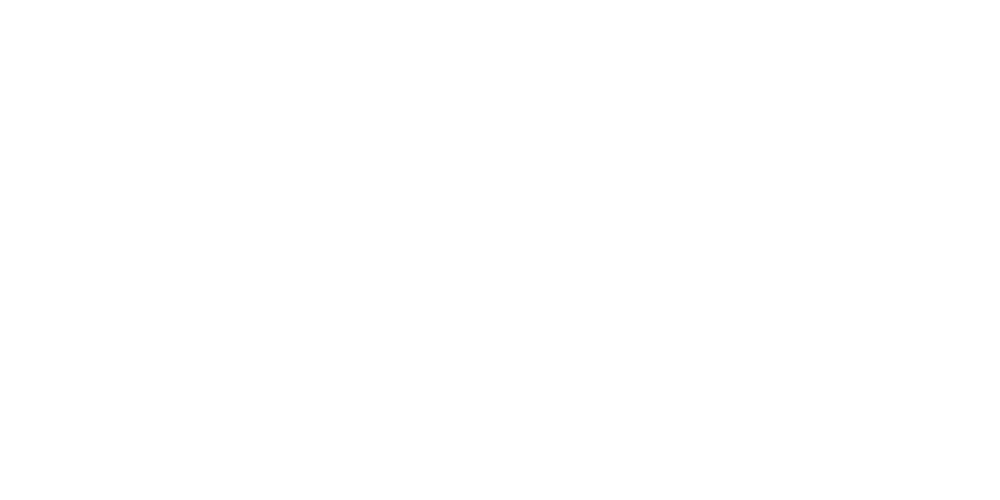

In [14]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.semilogy(history['train_loss'], label='Train Loss')
plt.semilogy(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
##########################################################
# Hyperparameter Optimization
##########################################################
# def objective(trial):
#     # Suggest hyperparameters
#     hidden_size = trial.suggest_int('hidden_size', 32, 256, step = 16)
#     num_layers = trial.suggest_int('num_layers', 2, 5)
#     learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
#     dropout = trial.suggest_float('dropout', 0.1,0.5)
#     weight_decay= trial.suggest_float('weight_decay',1e-5,1e-1, log=True)
    
#     seed_len = trial.suggest_int('seed_len', 12, 128)
#     pred_len = trial.suggest_int('pred_len', 1, 20)
#     batch_size = trial.suggest_int('batch_size', 16, 64, step = 8)
    
#     train_dataset = SequenceDataset(train_scaled, seed_len=seed_len, pred_len=pred_len)
#     val_dataset = SequenceDataset(val_scaled, seed_len=seed_len, pred_len=pred_len)
    
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
#     # Instantiate model with suggested hyperparameters
#     model = LSTMSOH(input_dim=4, hidden_dim=hidden_size, num_layers=num_layers, dropout=dropout).type(torch.float32).to(device)
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) #L2 regularization
#     history, _ = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs = 100, patience = 10)

#     # Extract last validation loss
#     last_val_loss = history['val_loss'][-1]
#     return last_val_loss

## Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # Extract best trial
# best_trial = study.best_trial
# print(f"Best trial: {best_trial}")

# best_hyperparams = study.best_trial.params
# print('Best hyperparameters:', best_hyperparams)

In [ ]:
def evaluate_multistep(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_seed, X_future, Y_target in test_loader:
            X_seed = X_seed.to(device)        # shape: (batch_size, seed_len, 4)
            X_future = X_future.to(device)    # shape: (batch_size, pred_len, 4)
            Y_target = Y_target.to(device)    # shape: (batch_size, pred_len)
            
            batch_size, seed_len, num_features = X_seed.shape
            pred_len = Y_target.shape[1]
            
            current_seq = X_seed.clone()  # 初始输入：历史的seed数据
            preds_steps = []
            
            for t in range(pred_len):
                # 预测下一时刻目标值
                pred = model(current_seq)  # 输出 shape: (batch_size,)
                preds_steps.append(pred.unsqueeze(1))
                
                # 从X_future中获取当前时刻的外生变量（含目标列）
                next_frame = X_future[:, t, :].clone()  # shape: (batch_size, num_features)
                # 将目标位置（假设第0列）替换为预测值
                next_frame[:, 0] = pred
                # 更新输入序列：移除最早的时间步，添加新的预测帧
                current_seq = torch.cat([current_seq[:, 1:, :], next_frame.unsqueeze(1)], dim=1)
            
            preds_steps = torch.cat(preds_steps, dim=1)  # (batch_size, pred_len)
            all_preds.append(preds_steps.cpu().numpy())
            all_targets.append(Y_target.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    r2 = r2_score(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    
    print(f"R2:{r2:.5f} | MAE: {mae:.5e} | RMSE:{rmse:.5e}")
    
    return all_preds, all_targets, r2, mae, rmse

In [17]:
# predict_autoregressive
def evaluate_singlepass(model, df, seq_len=24):
    model.eval()
    data_array = df[['SOH_ZHU', 'Current[A]', 'Voltage[V]', 'Temperature[°C]']].values.copy()
    preds = np.full(len(data_array), np.nan)

    with torch.no_grad():
        for i in range(seq_len, len(data_array)):
            input_seq = data_array[i - seq_len : i]  # shape (seq_len, 3)
            x_t = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
            pred_soc = model(x_t).item()
            preds[i] = pred_soc
            # Schreibe den SOC ins "SOC-ZHU"-Feld (Spalte 2) zurück,
            # damit es beim nächsten Schritt als Input dient
            data_array[i, 0] = pred_soc
    
    return preds

model_path = r'E:\00_Thesis\04_NNs\Results\LSTM\C,V,T\02\best_model.pth'
# model_path = 'best_model.pth'
# model = LSTMSOH(input_dim=4,hidden_dim=80,num_layers=5,dropout=0.5).to(device)
# model.load_state_dict(torch.load(model_path))    
all_preds = evaluate_singlepass(model, test_scaled, seq_len=13)
all_targets = test_scaled['SOH_ZHU'].values

valid_preds = all_preds[13:]
valid_targets = all_targets[13:]   

r2 = r2_score(valid_targets, valid_preds)
mae = mean_absolute_error(valid_targets, valid_preds)
rmse = np.sqrt(mean_squared_error(valid_targets, valid_preds))
    
print(f"R2:{r2:.5f} | MAE: {mae:.5e} | RMSE:{rmse:.5e}")
    


# #Load best model   
# # model_path = r'E:\00_Thesis\04_NNs\Results\LSTM\C,V,T\00\best_model.pth'
# model_path = 'best_model.pth'
# model = LSTMSOH(input_dim=4,hidden_dim=128,num_layers=2,dropout=0.2).to(device)
# model.load_state_dict(torch.load(model_path))

# seed_len = 24
# pred_len = 1
# batch_size = 16

# test_dataset = SequenceDataset(test_scaled, seed_len=seed_len, pred_len=pred_len)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# all_preds, all_targets, r2, mae, rmse = evaluate_model(model, test_loader)


R2:0.23443 | MAE: 2.93837e-02 | RMSE:3.50546e-02


R2:0.23443 | MAE: 2.93837e-02| RMSE:3.50546e-02


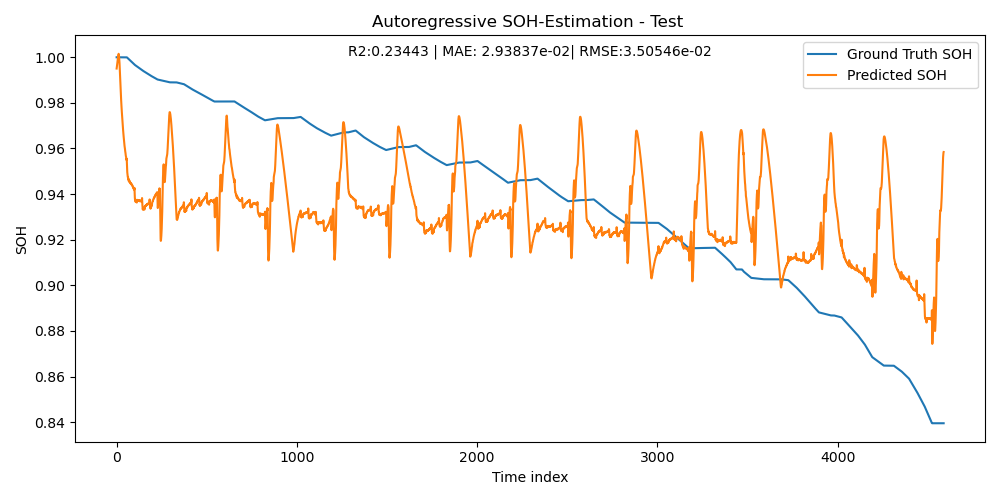

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(valid_targets, label="Ground Truth SOH")
plt.plot(valid_preds, label="Predicted SOH")
plt.title("Autoregressive SOH-Estimation - Test ")
plt.text(0.5, 0.95, f"R2:{r2:.5f} | MAE: {mae:.5e}| RMSE:{rmse:.5e}", 
         horizontalalignment='center', transform=plt.gca().transAxes)
print(f"R2:{r2:.5f} | MAE: {mae:.5e}| RMSE:{rmse:.5e}")
plt.xlabel("Time index")
plt.ylabel("SOH")
plt.legend()
plt.tight_layout()
plt.show()




In [ ]:
def autoregressive_inference(model, test_data, seed_len=13):
    """
    test_data: shape (T, num_features)
        The entire test time series in a single Tensor (or NumPy array).
    seed_len: int
        The length of the window used for the LSTM input.
    """
    model.eval()
    
    # Convert to torch.Tensor if it isn't already
    if not isinstance(test_data, torch.Tensor):
        test_data = torch.tensor(test_data, dtype=torch.float32)

    # Move to device
    test_data = test_data.to(model.device)

    T = test_data.shape[0]
    predictions = []

    # Start with the first `seed_len` steps as your 'window'
    current_seq = test_data[:seed_len].unsqueeze(0)  # shape (1, seed_len, num_features)

    # We will predict from time = seed_len to time = T-1
    # (the last possible "prediction" index)
    for t in range(seed_len, T):
        # Model expects shape (batch_size=1, sequence_length=seed_len, num_features=4)
        pred = model(current_seq)          # shape (1,) if your model outputs (batch_size,)
        pred_value = pred.item()
        
        # Store the prediction for time step t
        predictions.append(pred_value)
        
        # Create the next frame's features by copying the features from test_data[t]
        # except we replace the "SOH" column (index=0) with our predicted value
        next_frame = test_data[t].clone()  # shape (num_features,)
        next_frame[0] = pred_value
        
        # Shift the window: remove the earliest step, add this newly predicted frame
        current_seq = torch.cat([current_seq[:, 1:, :], next_frame.view(1,1,-1)], dim=1)
    
    return predictions
